
### Homework 4

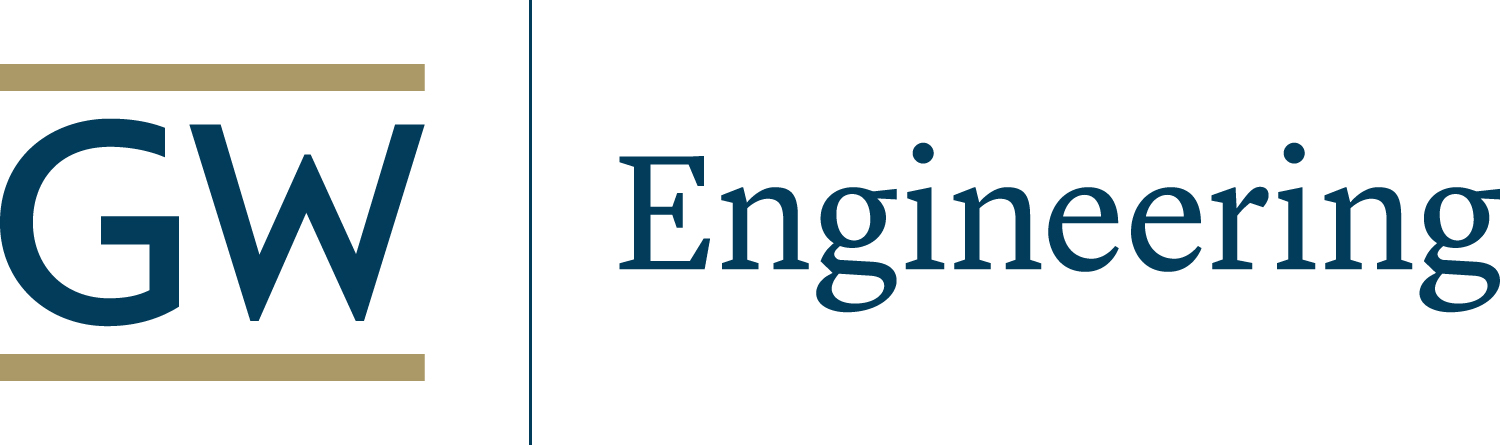

In [9]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

LABELS = ["Normal", "Fraud"]

Lets generate some sythetic data to learn with

In [ ]:
# # Parameters
# n_samples = 10000
# n_outliers = int(0.05 * n_samples)  # 5% outliers
# n_inliers = n_samples - n_outliers
# n_features = 20  # Number of features
# purturbation = 2
# # Generate inliers
# X_inliers, y_inliers = make_blobs(
#     n_samples=n_inliers, centers=3, n_features=n_features, cluster_std=1.5, random_state=42
# )

# # Generate outliers harder to detect (within the same distribution as inliers)
# X_outliers = X_inliers[np.random.choice(X_inliers.shape[0], n_outliers, replace=False)]
# X_outliers += np.random.normal(0, purturbation, size=X_outliers.shape)  # Slight random perturbation

# # Combine inliers and outliers
# X = np.vstack((X_inliers, X_outliers))
# y = np.hstack((np.zeros(n_inliers), np.ones(n_outliers)))  # 0 for inliers, 1 for outliers

# # Convert to DataFrame for exploration
# columns = [f"Feature{i+1}" for i in range(n_features)]
# df = pd.DataFrame(X, columns=columns)
# df["Class"] = y
# print(df.head())
# print(f"Shape of dataset: {df.shape}")


   Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0  3.940341 -5.627795 -5.400168 -2.874870 -0.303714  6.925473 -5.724213   
1 -8.304869  0.226904 -7.887974  5.950937 -3.133699  3.379946 -3.936539   
2 -3.352420  8.568961  5.172261  4.165096 -7.133306 -8.174301 -5.960024   
3 -7.023209  7.691721  3.848275  0.239702 -6.016757 -8.046281 -8.120688   
4 -3.235747  6.737443  6.993928  1.095063 -8.193996 -7.546760 -7.445081   

   Feature8  Feature9  Feature10  ...  Feature12  Feature13  Feature14  \
0  2.015699  1.731386  -6.750876  ...  -6.480604  -8.136016   7.567211   
1  0.005197  3.138350  -6.829766  ...   4.706732   8.832867   8.175991   
2  7.526849  1.863409   4.269203  ...   9.330089   7.788265  -3.923037   
3  5.473543  3.386129   2.246728  ...  11.254091   5.365012  -3.117824   
4  7.492863  0.834801   4.775176  ...   9.362550   6.296711  -4.229404   

   Feature15  Feature16  Feature17  Feature18  Feature19  Feature20  Class  
0   9.055622   6.436444  -2

In [8]:
P_disease = 0.05  # Prior
P_true_pos = 0.98
P_no_disease = 0.95
P_false_pos = .05 # this is an assumption

# P(Disease | Positive)
P_positive = (P_true_pos * P_disease) + (P_no_disease * P_false_pos)
P_disease_given_positive = (P_true_pos * P_disease) / P_positive

print(f"The probability of having the disease given a positive test result is {P_disease_given_positive:.4f}")

The probability of having the disease given a positive test result is 0.5078


In [10]:
df = pd.read_csv('/Users/ken.clements/code/SEAS8416/data/creditcard.csv')

/var/folders/p4/svf85_b50jvfz4dvm3yf5h0c0000gq/T/ipykernel_66130/2266408853.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

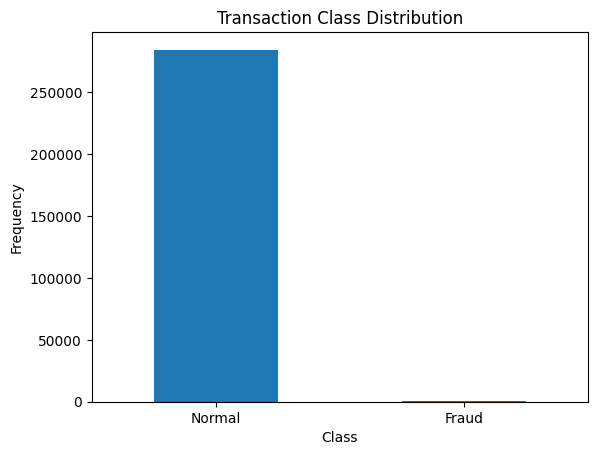

In [11]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [12]:
imbalance = (df['Class'] == 1).sum() / ((df['Class'] == 0).sum() + (df['Class'] == 1).sum())
print(f"The class imbalance is {imbalance}")

The class imbalance is 0.001727485630620034


In [13]:
X = df.drop(columns = 'Class')
y = df['Class']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #stratify retains the class balance - important for imbalnced data

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit transform the test set.  only transform.

In [18]:
# # Define the custom F1 scorer function (directly handle y_true and predictions)
# def custom_f1_score(estimator, X, y_true):

#     # Get the predictions: -1 for outliers, 1 for inliers
#     try:
#         y_pred = estimator.predict(X)
#     except:
#         y_pred = estimator.fit_predict(X)
    
#     # Convert predictions from {-1, 1} to binary {0, 1} for F1 score calculation
#     y_pred_binary = np.where(y_pred == -1, 1, 0)  # Convert -1 (outliers) to 1 and 1 (inliers) to 0
    
#     # Ensure y_true is in binary format (outliers = 0, inliers = 1)
#     # y_true_binary = np.where(y_true == 1, 0, 1)  # Convert outliers to 0 and inliers to 1
    
#     # Calculate F1 score
#     return f1_score(y_true, y_pred_binary)


In [147]:
# # Define the Isolation Forest model
# iso_forest = IsolationForest(random_state=42)

# # Use GridSearchCV with the custom F1 scorer
# param_grid_iforest = {
#     # 'n_estimators': [50, 100, 200],
#     # 'max_samples': [.5, 0.75],
#     # 'contamination': [.01, .05, .1],
#     # 'max_features': [0.5, .75]
#     'n_estimators': [200],
#     'max_samples': [.75],
#     'contamination': [.0017],
#     'max_features': [.75]
# }

# grid_search_iforest = GridSearchCV(iso_forest, param_grid_iforest, scoring=custom_f1_score, cv=3, verbose=2)
# grid_search_iforest.fit(X_train_scaled, y_train)

# best_model = grid_search_iforest.best_estimator_

# # Output best parameters and best F1 score
# print("Best Parameters:", grid_search_iforest.best_params_)
# print("Best F1 Score:", grid_search_iforest.best_score_)

best_estimator_if = IsolationForest(random_state=42, n_estimators=200, max_samples=.75, max_features=.75, contamination=.0017)
best_estimator_if.fit(X_train_scaled)

IsolationForest(contamination=0.0017, max_features=0.75, max_samples=0.75,
                n_estimators=200, random_state=42)

In [148]:
# print("Best Parameters:", grid_search_iforest.best_params_)
# print("Best F1 Score:", grid_search_iforest.best_score_)

In [149]:
# grid_search_iforest.best_estimator_

In [150]:
# from sklearn.tree import plot_tree

# tree = grid_search_iforest.best_estimator_.estimators_[4]  # Get the first tree

# # Visualize the tree
# plt.figure(figsize=(15, 10))
# plot_tree(tree, filled=True, rounded=True, max_depth=2)
# plt.title("Visualization of One Tree in the Isolation Forest")
# plt.show()

In [151]:
# # Custom scoring function using silhouette score
# def silhouette_scorer(estimator, X):
#     # Fit the model and predict labels
#     labels = estimator.fit_predict(X)
#     # The silhouette score is not defined if only one cluster is found
#     if len(set(labels)) > 1:  # Check if there are multiple clusters
#         return silhouette_score(X, labels)
#     else:
#         return -1  # Return a low score if there is only one cluster
    

## What is a silhouette score?

1. For each data point, the average distance (a_i) to other data points within the same cluster is calculated. This value represents the similarity level of the data point to others in its cluster.

2. For each data point, the average distance (b_i) to all other clusters it doesn’t belong to is computed. This value indicates how different the data point is from data points in other clusters.

3. The Silhouette score is calculated using the formula:

Silhouette Score = (b_i — a_i) / max(a_i, b_i)

In [152]:

# Define the parameter grid
# param_grid_ocsvm = {
#     'kernel': ['rbf'],  # Different kernels
#     'nu': [0.0017],  # The fraction of outliers
    # 'gamma': [0.1, 1],  # Only for 'rbf' kernel
    # 'degree': [3, 4],  # Only for 'poly' kernel
    # 'kernel': ['linear'],  # Different kernels
    # 'nu': [0.05],  # The fraction of outliers
    # 'gamma': [.1],  # Only for 'rbf' kernel
    # 'degree': [3],  # Only for 'poly' kernel
    # 'max_iter': [-1] #keep going till converges
# }

# Define the OCSVM model
# ocsvm = OneClassSVM()

# Perform GridSearchCV
# grid_search_ocsvm = GridSearchCV(ocsvm, param_grid_ocsvm, cv=3, verbose=2, scoring=silhouette_scorer)
# grid_search_ocsvm.fit(X_train_scaled)

# Access the best model
# best_estimator_ocsvm = grid_search_ocsvm.best_estimator_

# Print the best parameters and best score
# print("Best Parameters:", grid_search_ocsvm.best_params_)
# print("Best Score:", grid_search_ocsvm.best_score_)

best_estimator_ocsvm = OneClassSVM(kernel='rbf', nu=.0017)
best_estimator_ocsvm.fit(X_train_scaled)

OneClassSVM(nu=0.0017)

In [153]:
# # DBSCAN model
# dbscan = DBSCAN()

# # Custom scorer function for F1 score
# def custom_f1_scorer(estimator, X, y_true):
#     y_pred = estimator.fit_predict(X)
#     y_pred_binary = (y_pred == -1).astype(int)  # Convert DBSCAN output (-1 for outliers) to 1 for outliers
#     return f1_score(y_true, y_pred_binary)

# # Create custom scorer
# scorer = make_scorer(custom_f1_scorer, greater_is_better=True)

# # Grid search over DBSCAN hyperparameters
# param_grid = {
#     'eps': [3],      # Maximum distance for neighbors
#     'min_samples': [2],         # Minimum number of points to form a dense region
# #     'eps': [.3],      # Maximum distance for neighbors
# #     'min_samples': [3],         # Minimum number of points to form a dense region
# }

# grid_search_dbs = GridSearchCV(dbscan, param_grid, scoring=custom_f1_scorer, cv=3, verbose=2)
# grid_search_dbs.fit(X_train_scaled, y_train)


# # Best parameters and score
# print("Best Parameters:", grid_search_dbs.best_params_)
# print("Best F1 Score:", grid_search_dbs.best_score_)

best_estimator_dbs = DBSCAN(eps=3, min_samples=2)

IsolationForest(contamination=0.0017, max_features=0.75, max_samples=0.75,
                n_estimators=200, random_state=42): 195
Accuracy Score :
0.9977177767634563
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.33      0.30      0.31       148

    accuracy                           1.00     85443
   macro avg       0.66      0.65      0.65     85443
weighted avg       1.00      1.00      1.00     85443



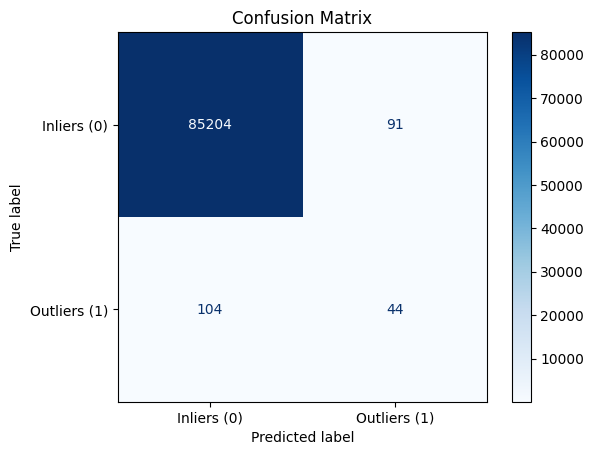

In [154]:
y_pred = best_estimator_if.predict(X_test_scaled)
y_pred = np.where(y_pred == 1, 0, 1)

n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format(best_estimator_if,n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix")
plt.show()

OneClassSVM(nu=0.0017): 974
Accuracy Score :
0.9886005875261871
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.08      0.49      0.13       148

    accuracy                           0.99     85443
   macro avg       0.54      0.74      0.56     85443
weighted avg       1.00      0.99      0.99     85443



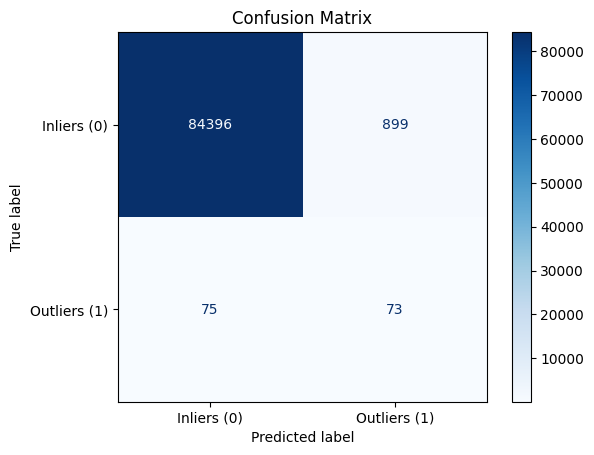

In [155]:
y_pred = best_estimator_ocsvm.predict(X_test_scaled)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format(best_estimator_ocsvm,n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix")
plt.show()


OneClassSVM(nu=0.0017): 6163
Accuracy Score :
0.927870042016315
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     85295
           1       0.02      0.70      0.03       148

    accuracy                           0.93     85443
   macro avg       0.51      0.81      0.50     85443
weighted avg       1.00      0.93      0.96     85443



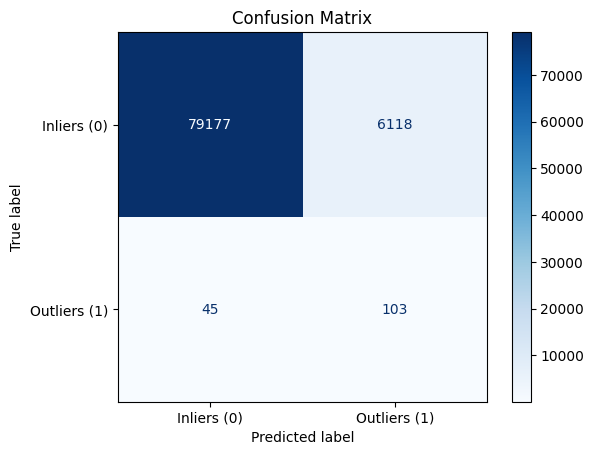

In [156]:

y_pred = best_estimator_dbs.fit_predict(X_test_scaled)
y_pred = (y_pred == -1).astype(int)  # Convert DBSCAN output (-1 for outliers) to 1 for outliers

n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format(best_estimator_ocsvm,n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix")
plt.show()

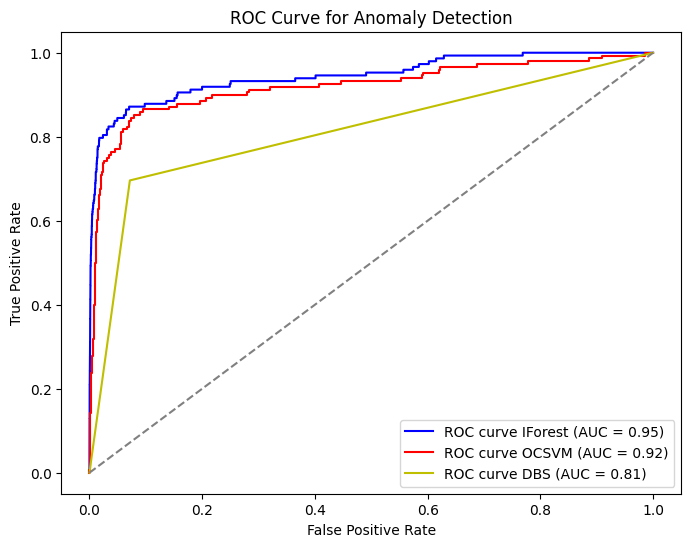

In [157]:
y_scores_if = best_estimator_if.decision_function(X_test_scaled)  # Anomaly score (the decision function)
y_scores_ocsvm = best_estimator_ocsvm.decision_function(X_test_scaled)  # Anomaly score (the decision function)
y_scores_dbs = best_estimator_dbs.labels_  # Anomaly score (the decision function)

y_scores_if = -y_scores_if
y_scores_ocsvm = -y_scores_ocsvm
y_scores_dbs = (y_scores_dbs == -1).astype(int)


fpr_if, tpr_if, _ = roc_curve(y_test, y_scores_if)  # True Positive Rate, False Positive Rate
roc_auc_if = auc(fpr_if, tpr_if)  # Compute the AUC (Area Under Curve)

fpr_ocsvm, tpr_ocsvm, _ = roc_curve(y_test, y_scores_ocsvm)  # True Positive Rate, False Positive Rate
roc_auc_ocsvm = auc(fpr_ocsvm, tpr_ocsvm)  # Compute the AUC (Area Under Curve)

# fpr_lof, tpr_lof, _ = roc_curve(y_test, y_scores_lof)  # True Positive Rate, False Positive Rate
# roc_auc_lof = auc(fpr_lof, tpr_lof)  # Compute the AUC (Area Under Curve)

fpr_dbs, tpr_dbs, _ = roc_curve(y_test, y_scores_dbs)  # True Positive Rate, False Positive Rate
roc_auc_dbs = auc(fpr_dbs, tpr_dbs)  # Compute the AUC (Area Under Curve)


plt.figure(figsize=(8, 6))
plt.plot(fpr_if, tpr_if, color='b', label=f'ROC curve IForest (AUC = {roc_auc_if:.2f})')
plt.plot(fpr_ocsvm, tpr_ocsvm, color='r', label=f'ROC curve OCSVM (AUC = {roc_auc_ocsvm:.2f})')
# plt.plot(fpr_lof, tpr_lof, color='g', label=f'ROC curve LoF (AUC = {roc_auc_lof:.2f})')
plt.plot(fpr_dbs, tpr_dbs, color='y', label=f'ROC curve DBS (AUC = {roc_auc_dbs:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('ROC Curve for Anomaly Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize, and thus make analyzing data points much easier and faster for machine learning algorithms without extraneous variables to process.

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

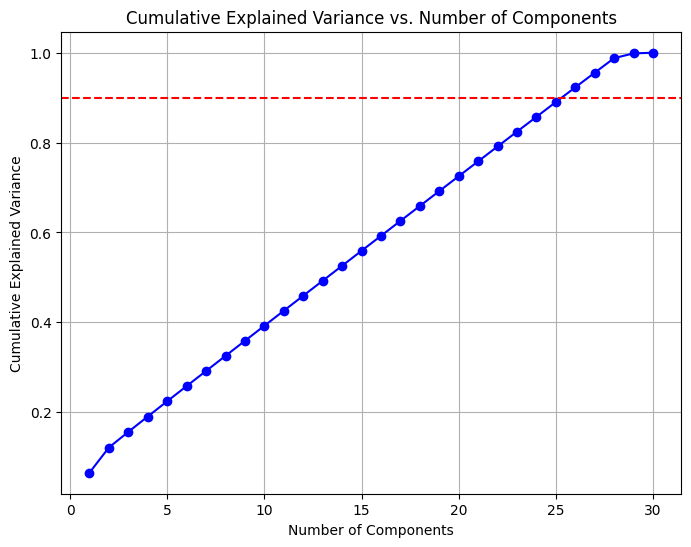

Number of components to retain 90% variance: 26
Original training data shape: (199364, 30)
Transformed training data shape: (199364, 26)
Original test data shape: (85443, 30)
Transformed test data shape: (85443, 26)


In [134]:
pca = PCA()
pca.fit(X_train_scaled)

# Step 5: Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Step 6: Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 7: Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='b')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--')  # 90% threshold
plt.show()

# Step 8: Choose the number of components that explain 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.9) + 1  # Add 1 because index is 0-based
print(f"Number of components to retain 90% variance: {n_components}")

# Step 9: Transform the training and test data using the optimal number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) # again do not fit on the test set.  that leaks information from train.

# Step 10: Print the shape of the transformed data
print(f"Original training data shape: {X_train_scaled.shape}")
print(f"Transformed training data shape: {X_train_pca.shape}")
print(f"Original test data shape: {X_test_scaled.shape}")
print(f"Transformed test data shape: {X_test_pca.shape}")


IsolationForest(contamination=0.0017, max_features=0.5, max_samples=0.5,
                n_estimators=200, random_state=42): 222
Accuracy Score :
0.9974017766230119
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.24      0.23      0.23       148

    accuracy                           1.00     85443
   macro avg       0.62      0.61      0.62     85443
weighted avg       1.00      1.00      1.00     85443



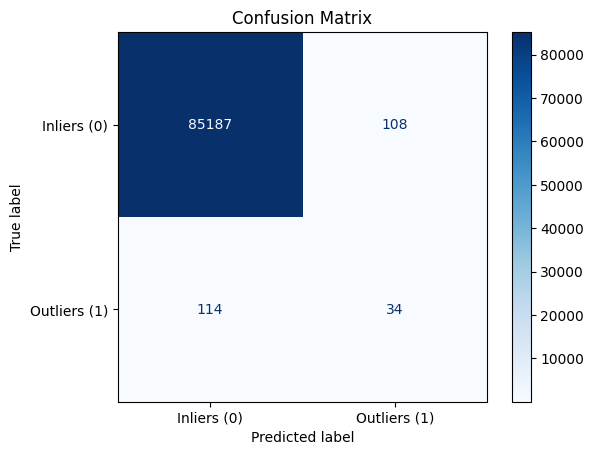

In [143]:
best_estimator_if = IsolationForest(random_state=42, n_estimators=200, max_samples=.5, max_features=.5, contamination=.0017)
best_estimator_if.fit(X_train_pca)

y_pred = best_estimator_if.predict(X_test_pca)
y_pred = np.where(y_pred == 1, 0, 1)

n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format(best_estimator_if,n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix")
plt.show()

OneClassSVM(nu=0.0017): 911
Accuracy Score :
0.9893379211872242
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.08      0.47      0.13       148

    accuracy                           0.99     85443
   macro avg       0.54      0.73      0.56     85443
weighted avg       1.00      0.99      0.99     85443



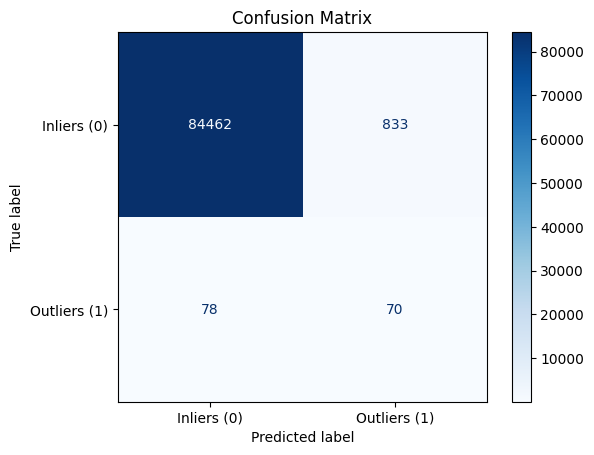

In [144]:
best_estimator_ocsvm = OneClassSVM(kernel='rbf', nu=.0017)
best_estimator_ocsvm.fit(X_train_pca)

y_pred = best_estimator_ocsvm.predict(X_test_pca)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format(best_estimator_ocsvm,n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix")
plt.show()


OneClassSVM(nu=0.0017): 5026
Accuracy Score :
0.9411771590417003
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     85295
           1       0.02      0.66      0.04       148

    accuracy                           0.94     85443
   macro avg       0.51      0.80      0.50     85443
weighted avg       1.00      0.94      0.97     85443



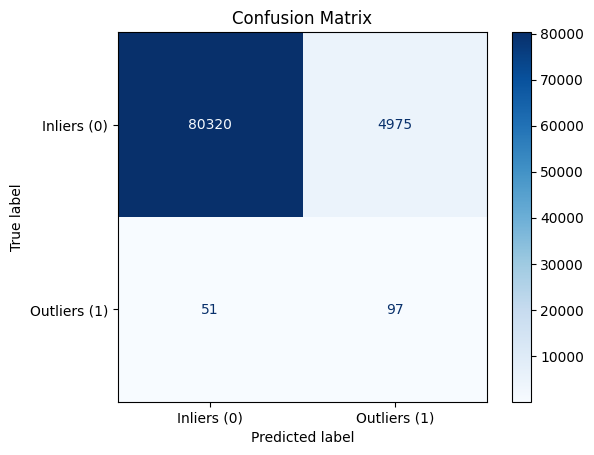

In [145]:
y_pred = best_estimator_dbs.fit_predict(X_test_pca)
y_pred = (y_pred == -1).astype(int)  # Convert DBSCAN output (-1 for outliers) to 1 for outliers

n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format(best_estimator_ocsvm,n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix")
plt.show()

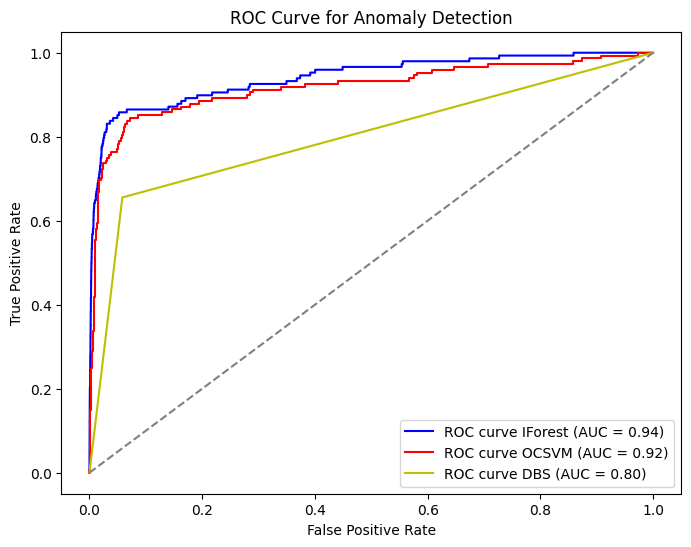

In [146]:
y_scores_if = best_estimator_if.decision_function(X_test_pca)  # Anomaly score (the decision function)
y_scores_ocsvm = best_estimator_ocsvm.decision_function(X_test_pca)  # Anomaly score (the decision function)
y_scores_dbs = best_estimator_dbs.labels_  # Anomaly score (the decision function)

y_scores_if = -y_scores_if
y_scores_ocsvm = -y_scores_ocsvm
y_scores_dbs = (y_scores_dbs == -1).astype(int)


fpr_if, tpr_if, _ = roc_curve(y_test, y_scores_if)  # True Positive Rate, False Positive Rate
roc_auc_if = auc(fpr_if, tpr_if)  # Compute the AUC (Area Under Curve)

fpr_ocsvm, tpr_ocsvm, _ = roc_curve(y_test, y_scores_ocsvm)  # True Positive Rate, False Positive Rate
roc_auc_ocsvm = auc(fpr_ocsvm, tpr_ocsvm)  # Compute the AUC (Area Under Curve)

# fpr_lof, tpr_lof, _ = roc_curve(y_test, y_scores_lof)  # True Positive Rate, False Positive Rate
# roc_auc_lof = auc(fpr_lof, tpr_lof)  # Compute the AUC (Area Under Curve)

fpr_dbs, tpr_dbs, _ = roc_curve(y_test, y_scores_dbs)  # True Positive Rate, False Positive Rate
roc_auc_dbs = auc(fpr_dbs, tpr_dbs)  # Compute the AUC (Area Under Curve)


plt.figure(figsize=(8, 6))
plt.plot(fpr_if, tpr_if, color='b', label=f'ROC curve IForest (AUC = {roc_auc_if:.2f})')
plt.plot(fpr_ocsvm, tpr_ocsvm, color='r', label=f'ROC curve OCSVM (AUC = {roc_auc_ocsvm:.2f})')
# plt.plot(fpr_lof, tpr_lof, color='g', label=f'ROC curve LoF (AUC = {roc_auc_lof:.2f})')
plt.plot(fpr_dbs, tpr_dbs, color='y', label=f'ROC curve DBS (AUC = {roc_auc_dbs:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('ROC Curve for Anomaly Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()